# Fine-tuning ROBERTA + DEIT for binary visual question answering (VQA)


* DeiT paper: https://arxiv.org/pdf/2012.12877.pdf
* DeiT docs: https://huggingface.co/docs/transformers/model_doc/deit
* ROBERTA paper: https://arxiv.org/pdf/1907.11692.pdf
* ROBERTA docs: https://huggingface.co/docs/transformers/model_doc/roberta

## Set-up environment: Imports and Configurations

### Import libraries

In [26]:
import os
import math
import warnings
import json
import numpy as np
import pandas as pd
import evaluate
import requests
import torch
import random
import argparse
import torchvision
from torch import nn
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel, RobertaModel, RobertaTokenizer
import torchvision.transforms as T
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import nltk
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, f1_score
from IPython.display import clear_output, display
from datasets import load_dataset, set_caching_enabled
from transformers import TrainingArguments, AutoFeatureExtractor, AutoModel, Trainer, logging, AutoTokenizer

In [44]:
DATA_PATH = '/home/jovyan/ars/vqa-research/VQA/data/'
ANNOTATIONS_PATH = DATA_PATH + 'abstract_v002_train2017_annotations.json'
QUESTIONS_PATH = DATA_PATH + 'OpenEnded_abstract_v002_train2017_questions.json'
VQA_TRAIN_PATH = DATA_PATH + 'VQA_train.csv'
IMAGE_DIR = DATA_PATH + 'scene_img_abstract_v002_train2017/'
IMAGE_PREFIX = 'abstract_v002_train2015_'
IMAGE_FORMAT = '.png'

In [45]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preprocess data

In [46]:
vqa_data = pd.read_csv(VQA_TRAIN_PATH, index_col=0)

with open(ANNOTATIONS_PATH) as f:
    annotations = json.load(f)['annotations']

with open(QUESTIONS_PATH) as f:
    questions = json.load(f)['questions']

In [47]:
def to_lowercase(vqa_data):
    X = vqa_data.copy()
    X[['question', 'answer']].apply(lambda x: x.str.lower(), axis=0)
    return X

In [48]:
vqa_data = to_lowercase(vqa_data)

In [49]:
def add_img_paths(vqa_data, img_dir, prefix, format='.png'):
    X = vqa_data.copy()
    X['image_path'] = \
        img_dir + \
        prefix + \
        (12 - vqa_data['image_id'].astype('str').str.len()).apply(lambda x: x * '0') + \
    vqa_data['image_id'].astype('str') + IMAGE_FORMAT
    return X

In [50]:
vqa_data = add_img_paths(vqa_data, IMAGE_DIR, IMAGE_PREFIX, IMAGE_FORMAT)

In [51]:
vqa_data.head()

,image_id,question,question_id,answer,image_path
0,87,Is the boy having wine?,870,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
1,900000870,Is the boy having wine?,900000870,no,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
2,14962,Is it night time?,149620,no,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
3,900149620,Is it night time?,900149620,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
4,8277,Is the boy hanging from monkey bars?,82771,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...


In [51]:
vqa_data['label'] = vqa_data['answer'].apply(lambda x: 1 if x == 'yes' else 0)

In [52]:
# del vqa_data['image_id']
# del vqa_data['question_id']

train_df, temp_data = train_test_split(vqa_data, test_size=0.3, random_state=42)
test_df, eval_df = train_test_split(temp_data, test_size=0.5, random_state=42)

train_df.shape, test_df.shape, eval_df.shape

((15438, 5), (3308, 5), (3309, 5))

In [53]:
train_df

,image_id,question,question_id,answer,image_path
3069,16900,Is the dog on the rug?,169001,no,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
9276,15911,Is that a dog?,159112,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
94,19825,Can you see the moon?,198251,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
18082,12035,Is the book yellow?,120352,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
8797,900140120,Is the girl getting ready to feed the animals?,900140120,no,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
...,...,...,...,...,...
11964,900016782,Are the man and the woman drinking the same wine?,900016782,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
21575,900050412,Is the rabbit skittish?,900050412,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
5390,19729,Are the number of windows half the number of p...,197292,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...
860,900074192,Are the woman's feet on the floor?,900074192,yes,/home/jovyan/ars/vqa-research/VQA/data/scene_i...


In [87]:
train_df.rename(columns={'image_path': 'image_id'}, inplace=True)
eval_df.rename(columns={'image_path': 'image_id'}, inplace=True)

In [54]:
train_df.to_csv("/home/jovyan/ars/vqa-research/VQA/data/data_splits/data_train.csv", index=False)
test_df.to_csv("/home/jovyan/ars/vqa-research/VQA/data/data_splits/data_test.csv", index=False)
eval_df.to_csv("/home/jovyan/ars/vqa-research/VQA/data/data_splits/data_eval.csv", index=False)

In [10]:
device = torch.device('cuda')
dataset = load_dataset("csv", data_files={"train": "data_train.csv","test": "data_eval.csv"})

Found cached dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-9081441611791805/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id'],
        num_rows: 15438
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id'],
        num_rows: 3309
    })
})

In [12]:
with open("answer_space.txt") as f:
    all_answers = f.read().splitlines()

def process_answer(answer):
    # Select the 1st answer if multiple answers are provided
    answer = answer.replace(" ", "")
    if "," in answer:
        answer = answer.split(",")[0]
    return all_answers.index(answer)

def transform_example(example):
    label = [process_answer(ans) for ans in example['answer']]
    return {'label': label}
dataset = dataset.map(transform_example, batched=True)

dataset

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-9081441611791805/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-9e5e4eb0b9446de5.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-9081441611791805/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-5ea5a08f3e6e8691.arrow


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 15438
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 3309
    })
})

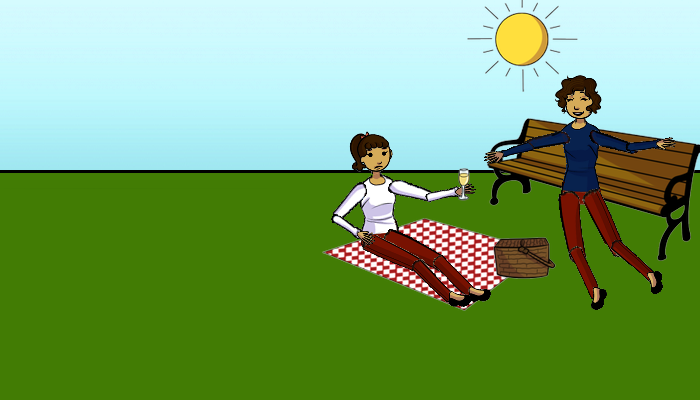

Question: Is there anyone that she can share her drink with?
Answer: yes (Label: 1)


In [13]:
def dataset_example(train_data=True, example_id=None):
    if train_data:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if example_id is not None:
        example_id = example_id
    else:
        example_id = random.randint(0, len(data) - 1)

    image_id = data[example_id]["image_id"]
    image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
    image = Image.open(image_path)
    display(image)

    question = data[example_id]["question"]
    answer = data[example_id]["answer"]
    label = data[example_id]["label"]
    print("Question: " + str(question))
    print("Answer: " + str(answer) + " (Label: " + str(label) + ")")
dataset_example()

In [14]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:

        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0


    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

<>:9: DeprecationWarning: invalid escape sequence \i
<>:20: DeprecationWarning: invalid escape sequence \d
<>:9: DeprecationWarning: invalid escape sequence \i
<>:20: DeprecationWarning: invalid escape sequence \d
<>:9: DeprecationWarning: invalid escape sequence \i
<>:20: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_85276/2074375980.py:9: DeprecationWarning: invalid escape sequence \i
  """
/tmp/ipykernel_85276/2074375980.py:20: DeprecationWarning: invalid escape sequence \d
  """


In [15]:
def wup_measure_for_batch(labels1, labels2):
    wup_scores = []
    for i in range(len(labels1)):
        label1, label2 = labels1[i], labels2[i]
        wup_score = wup_measure(all_answers[label1], all_answers[label2])
        wup_scores.append(wup_score)
    return np.mean(wup_scores)

In [17]:
S1 = np.random.randint(len(all_answers), size=5)
S2 = np.random.randint(len(all_answers), size=5)
print([all_answers[id] for id in S1])
print([all_answers[id] for id in S2])
print("WUP for two completely unrelated label sequences: ", wup_measure_for_batch(S1, S2))
print("WUP for two same label sequences: ", wup_measure_for_batch(S1, S1))

['yes', 'yes', 'no', 'yes', 'no']
['no', 'no', 'yes', 'yes', 'yes']
WUP for two completely unrelated label sequences:  0.2188235294117647
WUP for two same label sequences:  1.0


In [18]:
def compute_metrics(to_evaluate):
    predicted_labels, labels = to_evaluate
    best_predicted = np.argmax(predicted_labels, axis=-1)
    wups = wup_measure_for_batch(labels, best_predicted)
    accuracy = accuracy_score(labels, best_predicted)
    f1 = f1_score(labels, best_predicted, average='macro')
    return {"wups": wups, "acc": accuracy, "f1": f1}

## Create class for visual and text modalities

In [19]:
@dataclass
class OverallExtractor:
   
    MyTokenizer: AutoTokenizer                                    
    MyFeatureExtractor: AutoFeatureExtractor

    def __call__(self, RawBatch):
        question_list = RawBatch['question'] if isinstance(RawBatch, dict) else [i['question'] for i in RawBatch]
        image_id_list = RawBatch['image_id'] if isinstance(RawBatch, dict) else [i['image_id'] for i in RawBatch]
        label_list = RawBatch['label'] if isinstance(RawBatch, dict) else [i['label'] for i in RawBatch]

        encoded_text = self.MyTokenizer(
            text=question_list,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        processed_images = self.MyFeatureExtractor(
            images=[Image.open(os.path.join("..", "dataset", "images", image_id + ".png")).convert('RGB') for image_id in image_id_list],
            return_tensors="pt",
        )

        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
            "pixel_values": processed_images['pixel_values'].squeeze(),
            "labels": torch.tensor(label_list, dtype=torch.int64)
        }


In [20]:
class RobertaDeitModel(nn.Module):
    def __init__(self, num_labels=2, intermediate_dim=512, pretrained_text_name=None, pretrained_image_name=None):
        super().__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Load the pretrained models for text and image from Hugging Face model hub
        self.text_encoder = AutoModel.from_pretrained(pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(pretrained_image_name)

        # Define a fully connected layer for fusion of text and image embeddings
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(intermediate_dim, num_labels)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, pixel_values, attention_mask=None, token_type_ids=None, labels=None):

        # Pass the input text through the text encoder                              
        encoded_text = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)

        # Pass the input image through the image encoder                           
        encoded_image = self.image_encoder(pixel_values=pixel_values, return_dict=True)

        # Concatenate the text and image embeddings and pass them through the fusion layer
        fused_output = self.fusion(torch.cat([encoded_text.pooler_output, encoded_image.pooler_output], dim=1))
        predicted_labels = self.classifier(fused_output)

        # Return the predicted labels
        out = {"predicted_labels": predicted_labels}

        # If labels are provided, compute the loss
        if labels is not None:
            loss = self.criterion(predicted_labels, labels)
            out["loss"] = loss

        return out

# Train model

In [56]:
args = TrainingArguments(
    output_dir="/home/jovyan/ars/vqa-research/VQA/ROBERTA_DEIT_model/checkpoint/robert_deit",
    seed=12345,
    evaluation_strategy="steps",   
    eval_steps=100,                 # Number of update steps between two evaluations
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    remove_unused_columns=False,    #remove the unused columns from the dataset, Helps speed up training
    num_train_epochs=5,        
    fp16=True,
    learning_rate=5e-4,
    weight_decay=1e-4,
    dataloader_num_workers=8,
    load_best_model_at_end=True,   #loads the best model based on the evaluation metric at the end of training
)

In [22]:
text_model='roberta-base'
image_model='facebook/deit-base-distilled-patch16-224'
multimodal_model='robert_deit'

collator = OverallExtractor(MyTokenizer=AutoTokenizer.from_pretrained(text_model),MyFeatureExtractor=AutoFeatureExtractor.from_pretrained(image_model),)
model = RobertaDeitModel(pretrained_text_name=text_model, pretrained_image_name=image_model).to(device)

args_copy = deepcopy(args)
args_copy.output_dir = os.path.join("..", "checkpoint", multimodal_model)

multi_trainer = Trainer(
    model,
    args_copy,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collator,
    compute_metrics=compute_metrics
)

train_multi_metrics = multi_trainer.train()
eval_multi_metrics = multi_trainer.evaluate()

/home/jovyan/.imgenv-ars-100-2-80gb-0/lib/python3.7/site-packages/transformers/models/deit/feature_extraction_deit.py:31: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were n

/home/jovyan/.imgenv-ars-100-2-80gb-0/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Wups,Acc,F1
100,0.695700,0.693095,0.513978,0.502267,0.459179
200,0.695900,0.693614,0.519290,0.507706,0.336741
300,0.693800,0.693252,0.519290,0.507706,0.336741
400,0.695000,0.693150,0.519290,0.507706,0.336741
500,0.693900,0.694663,0.519290,0.507706,0.397731
600,0.695000,0.694979,0.503945,0.491992,0.329755
700,0.694300,0.693542,0.519290,0.507706,0.336741
800,0.693600,0.693020,0.519290,0.507706,0.336741
900,0.693200,0.693064,0.519290,0.507706,0.336741
1000,0.692500,0.693739,0.519585,0.508008,0.339057


/home/jovyan/.imgenv-ars-100-2-80gb-0/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jovyan/.imgenv-ars-100-2-80gb-0/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jovyan/.imgenv-ars-100-2-80gb-0/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/jovyan/.imgenv-ars-100-2-80gb-0/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68

In [23]:
eval_multi_metrics

{'eval_loss': 0.693738579750061,
 'eval_wups': 0.5195847332586706,
 'eval_acc': 0.5080084617709277,
 'eval_f1': 0.3390567902640214,
 'eval_runtime': 11.7459,
 'eval_samples_per_second': 281.716,
 'eval_steps_per_second': 4.427,
 'epoch': 5.0}

## Evaluate and inference model

In [58]:
model = OverallVQAModel(pretrained_text_name=text_model, pretrained_image_name=image_model) 
model.load_state_dict(torch.load("/home/jovyan/ars/vqa-research/VQA/checkpoint/robert_deit/checkpoint-1200/pytorch_model.bin"))
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkp

OverallVQAModel(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [59]:
MyExample = collator(dataset["test"][1200:1205])
input_ids = MyExample["input_ids"].to(device)
token_type_ids = MyExample["token_type_ids"].to(device)
attention_mask = MyExample["attention_mask"].to(device)
pixel_values = MyExample["pixel_values"].to(device)
labels = MyExample["labels"].to(device)
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)
preds = output["predicted_labels"].argmax(axis=-1).cpu().numpy()
preds

array([0, 1, 1, 1, 0])

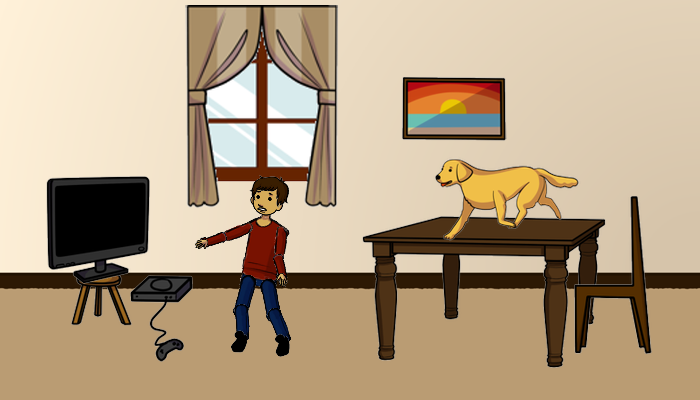

Question: Is there anything on the table?
Answer: yes (Label: 1)
Predicted Answer:	 no


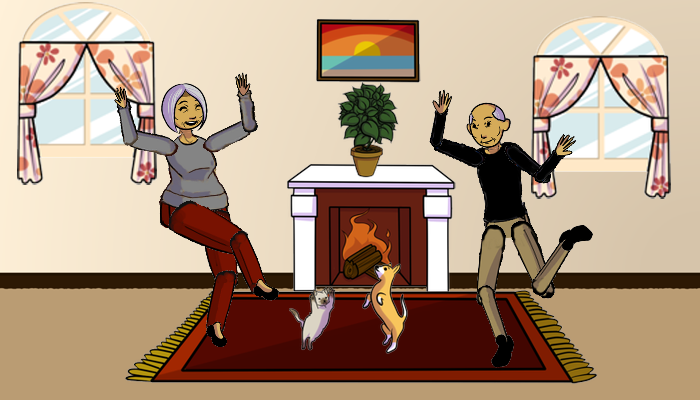

Question: Are the man and woman dancing?
Answer: yes (Label: 1)
Predicted Answer:	 no
No. of trainable parameters:	211,824,386


In [148]:
def number_of_trainable_parameters(model):
    num_params = 0
    for p in model.parameters():
        if p.requires_grad:
            num_params += p.numel()
    print("No. of trainable parameters:\t{0:,}".format(num_params))

for i in range(1103,1105):
    dataset_example(train_data=False, example_id=i)
    print("Predicted Answer:\t", all_answers[preds[i-1104]])

number_of_trainable_parameters(model)